# Elaboración de mapas (mapmaking)

### Código de Sigurd Naess, adaptado por Jeff McMahon. Traducción por Cristian Vargas

Los telescopios de CMB observan escaneando el cielo y registrando la respuesta de cada detector como una función del tiempo, cómo también hacia donde está apuntando. La serie de tiempo de respuesta del detector se conoce comúnmente como datos ordenados por tiempo o TOD (del inglés Time Ordered Data). Cada campo de CMB generalmente se observa muchas veces en el transcurso de una o más temporadas, lo que produce una gran cantidad de TOD superpuestos. 

La estrategia de escaneo es típicamente ajustar el telescopio a una elevación (por ejemplo 60 grados con respecto al horizonte) y moverlo de izquierda a derecha. En los polos, la rotación del cielo se alinea con el eje de elevación del telescopio, lo que da como resultado exploraciones paralelas en las coordenadas del cielo (por ejemplo si estás en el polo sur verás las estrellas rotar de forma paralela y el polo sur celeste estará aproximadamente en el cenit). En los sitios de latitudes medias no existe tal alineación y la rotación del cielo puede producir escaneos entrecruzados o en forma de X si es que estamos observando de izquierda a derecha en cierta elevación. Luego de observar por temporadas los TOD se procesan para reconstruir los mapas. 

En este cuadernillo (1) modelaras los TOD para un mapa que se observa horizontal y verticalmente para crear un conjunto de TOD reticulados, (2) agregaras ruido 1/f para crear TOD similares a los que generaría un instrumento CMB y (3) utilizaras varios códigos de creación de mapas para reconstruir mapas a partir de estos flujos de tiempo. Los códigos de creación de mapas incluyen (i) un promedio agrupado simple que funciona bien si los TOD tienen un ruido blanco insignificante (del instrumento (por ejemplo, datos de polarización de placa de media onda desmodulados) o blanqueando previamente los datos con un filtro), y (ii) un método iterativo de máxima verosimilitud (maximum likelihood) que tiene en cuenta las correlaciones de ruido de la atmósfera.

Los ejercicios te guiarán a través de las diferencias entre mapas entrecruzados y no entrecruzados, y los impactos del filtrado antes y después de la creación de mapas.


## Primero leemos en las librerias necesarias de los módulos de código anteriores.

In [1]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits

#%cd /Users/cvargas/CMBAnalysis_SummerSchool  ## poner directorio donde viven los mapas y las librerias aquí

%matplotlib inline
import constantes as cs # modulo de constantes

from cmb_modulos import * # modulo de funciones
N = int(cs.N)
c_min = cs.c_min
c_max = cs.c_max
X_ancho =cs.X_ancho
Y_ancho = cs.Y_ancho
tamaño_haz_fwhm = cs.tamaño_haz_fwhm

tamaño_pix = cs.tamaño_pix
print("tamaño del pixel: ", tamaño_pix)

Numero_de_Fuentes  = cs.Numero_de_Fuentes
Amplitud_de_Fuentes = cs.Amplitud_de_Fuentes
Numero_de_Fuentes_EX = cs.Numero_de_Fuentes_EX
Amplitud_de_Fuentes_EX = cs.Amplitud_de_Fuentes_EX

Numero_de_Cumulos_SZ  = cs.Numero_de_Cumulos_SZ
Amplitud_promedio_de_cumulos_SZ = cs.Amplitud_promedio_de_cumulos_SZ
SZ_beta = cs.SZ_beta
SZ_Theta_central = cs.SZ_Theta_central


tamaño del pixel:  0.5


## Recalculando los resultados de las etapas anteriores

Esto crea un mapa con CMB, fuentes puntuales y fuentes SZ. También convoluciona el mapa con el haz. A diferencia de las simulaciones basadas en mapas anteriores, el ruido se agregará en las series temporales que se calculan a continuación.

promedio del mapa: -10.196023105676021 , media cuadrática (rms) del mapa: 95.45618137853843


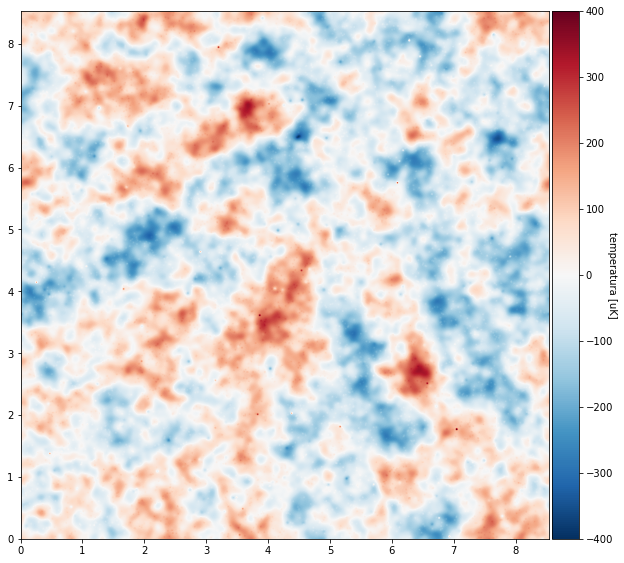

In [2]:
## Crear el mapa CMB
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
CMB_T = crear_mapa_CMB_T(N,tamaño_pix,ell,DlTT)

## crear un mapa de fuentes puntuales
MapaFP = componente_Poisson(N,tamaño_pix,Numero_de_Fuentes,Amplitud_de_Fuentes) 
MapaFP +=  componente_Exponencial(N,tamaño_pix,Numero_de_Fuentes_EX,Amplitud_de_Fuentes_EX)

## crear un mapa SZ
MapaSZ,catSZ = componente_SZ(N,tamaño_pix,Numero_de_Cumulos_SZ,\
                            Amplitud_promedio_de_cumulos_SZ,SZ_beta,SZ_Theta_central,False)

## agréguelos todos juntos para obtener el mapa del cielo en una sola frecuencia
mapa_total = CMB_T + MapaFP + MapaSZ


## convolucionar con el haz
CMB_T_convolucionado = mapa_convolucionado_con_haz_gaussiano(N,tamaño_pix,tamaño_haz_fwhm,mapa_total)

## graficar el resultado
p=Graficar_Mapa_CMB(CMB_T_convolucionado,c_min,c_max,X_ancho,Y_ancho)

## guardar el resultado como "cielo", una variable que representa el cielo simulado
## que mapearemos a continuación

cielo = mapa_total

## Generando flujos de tiempo a partir de un mapa del cielo simulado

Esta es la primera pieza nueva del cuadernillo. En esta sección simulamos el escaneo del telescopio a través del mapa. Para simplificar, consideramos dos direcciones de escaneo: izquierda-derecha y arriba-abajo. Este código genera una lista de píxeles (coordenadas x e y) en el orden en que se observan.



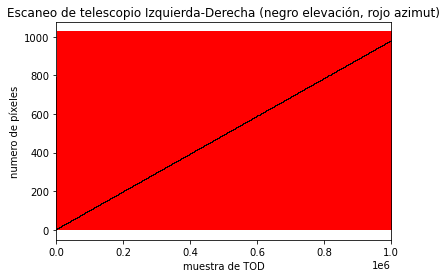

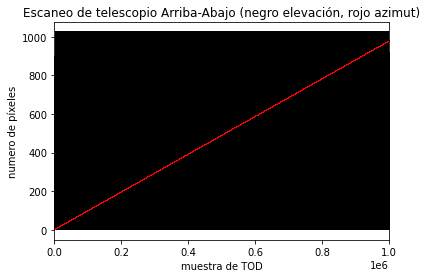

In [3]:
## una función para devolver la secuencia de índices de píxeles tal como se "observan" en estas simulaciones
def sim_puntero(mapa, direccion=0):
    """
    Simula un telescopio escaneando el mapa dado. El patrón de exploración es el más simple posible: las
    muestras dan hacia el centro de cada píxel, y escaneamos por fila (direccion=0) o por columnas (direccion=1).
    """
    # El puntero es un arreglo [{y,x},nsamp] de posiciones de píxeles
    #crea los arreglos de los índices x e y en el mapa
    pixmap = np.mgrid[:mapa.shape[-2],:mapa.shape[-1]] 
    #invierte filas para que los escaneos vayan de un lado a otro
    pixmap[1,1::2, :] = pixmap[1,1::2, ::-1]      
    #organiza estos para escaneos Izquierda-Derecha   
    if direccion == 0: 
        puntero = pixmap.reshape(2,-1) 
    #organiza estos para escaneos Arriba-Abajo
    else:        
        puntero = np.roll(pixmap,1,axis=0).reshape(2,-1) 
    return puntero


## genera escaneos izquierda-derecha
puntero_id = sim_puntero(cielo, 0)

## genera escaneos arriba-abajo
puntero_aa = sim_puntero(cielo, 1)


plt.plot(puntero_id[1,:],"r,")
plt.plot(puntero_id[0,:],"k,")
plt.title("Escaneo de telescopio Izquierda-Derecha (negro elevación, rojo azimut)")

plt.ylabel("numero de píxeles")
plt.xlabel("muestra de TOD")
plt.xlim(0,1e6)
plt.show()

plt.plot(puntero_aa[0,:],"k,")
plt.plot(puntero_aa[1,:],"r,")
plt.title("Escaneo de telescopio Arriba-Abajo (negro elevación, rojo azimut)")

plt.ylabel("numero de píxeles")
plt.xlabel("muestra de TOD")
plt.xlim(0,1e6)
plt.show()

<font color='red'>EJERCICIO: </font> Haz zoom en el gráfico ajustando el limite del eje x a un rango mucho más pequeño. Describe la estrategia de escaneo basado en lo que ves en estos gráficos.


In [4]:
# haz tus gráficos aquí

#### la discusión va acá

### TODs sin ruido

Este código toma la información de los puntertos generados arriba y crea un TOD sin ruido

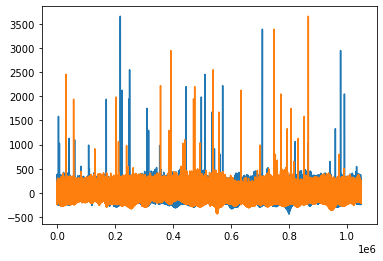

In [5]:
def Observar_mapa(mapa, puntero):
    """Matriz de punteros: Mapa proyectado a TOD"""
    puntero =  np.round(puntero).astype(int)
    ## devuelve el valor del mapa en cada punto, esto forma el flujo de tiempo simulado
    return mapa[puntero[0],puntero[1]] 

tod_sinruido_id = Observar_mapa(cielo,puntero_id)
tod_sinruido_aa = Observar_mapa(cielo,puntero_aa)

plt.plot(tod_sinruido_id)
plt.plot(tod_sinruido_aa)
plt.show()


<font color='red'>EJERCICIO: </font>  Explica los peaks en el TOD y discute si el rms del TOD tiene sentido.


#### la discusión va acá

<font color='red'>EJERCICIO OPCIONAL: </font> Agrega el impacto de las constantes de tiempo del detector que borronea estos TOD. Es mejor hacer este ejercicio después de completar el resto del cuadernillo para que su impacto se pueda propagar a través de todo este código a los mapas. Esto le permitirá modelar el impacto de este efecto.

NOTA: [este artículo de wikipedia (en inglés)](https://en.wikipedia.org/wiki/Exponential_smoothing) es útil para el modelado de filtros exponenciales (por ejemplo, constantes de tiempo del detector). Este enfoque se puede implementar con arreglos utilizando la función np.roll.

### Agregando ruido al TOD

Aquí construimos un espectro de potencia de ruido para el ruido atmosférico e instrumental. De forma predeterminada, asumimos que el ruido instrumental tiene una amplitud de 40 $\mu$K por muestra (1/2 arcmin pixels), que es similar a la exposición completa de ACT-MBAC o SPT-SZ, que rondaban los 20 $\mu$K por arcominuto (SPT llegó un poco más bajo). La señal atmosférica se modela como una ley de potencia simple con un codo de 0.1 s 1/f y un escaneo que gasta $1/240$ s en cada píxel, lo que equivale a una velocidad de escaneo de $1^\circ/$s.

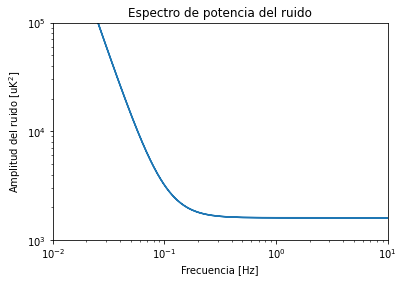

In [6]:
def sim_espectro_ruido(nmues, dt=.00416, fcodo=0.1, alfa=3, sigma=40):
    """Construye un modelo de atmósfera simple + ruido blanco y lo devuelve
    como espectro de potencia."""
    frec   = np.abs(np.fft.fftfreq(nmues, dt))
    return (1+(np.maximum(frec,frec[1])/fcodo)**-alfa)*sigma**2

espectro_ruido_id = sim_espectro_ruido(puntero_id.shape[-1], dt=.00416, fcodo=0.1, alfa=3, sigma=40)
espectro_ruido_aa = sim_espectro_ruido(puntero_aa.shape[-1], dt=.00416, fcodo=0.1, alfa=3, sigma=40) 

frec =  np.abs(np.fft.fftfreq(puntero_id.shape[-1], .00416))

plt.loglog(frec,espectro_ruido_id)
plt.title("Espectro de potencia del ruido")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud del ruido [uK$^{2}$]")
plt.ylim(1e3,1e5)
plt.xlim(1e-2,10)
plt.show()


El siguiente paso es generar una realización de este ruido y agregarlo a la serie temporal sin ruido.

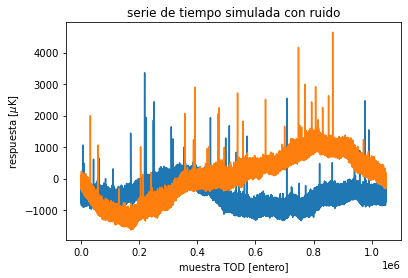

In [7]:
def sim_tod(mapa, puntero, espectro_ruido):
    """Simula un TOD ruidoso usando el modelo d = Pm + n"""
    tod       = Observar_mapa(mapa, puntero)
    aleatorio = np.fft.fft(np.random.standard_normal(tod.shape[-1]))
    fruido    = aleatorio * espectro_ruido**0.5
    tod      += np.fft.ifft(fruido).real
    return tod

tod_id = sim_tod(cielo,puntero_id,espectro_ruido_id)
tod_aa = sim_tod(cielo,puntero_aa,espectro_ruido_aa)

plt.plot(tod_id)
plt.plot(tod_aa)

plt.title("serie de tiempo simulada con ruido")
plt.ylabel("respuesta [$\mu$K]")
plt.xlabel("muestra TOD [entero]")
plt.show()

<font color='red'>EJERCICIO: </font> Los detectores típicos tienen ruidos de ${\sim}300 \mu$K por $\sqrt{s}$. Haz un gráfico de cómo se ve un flujo de tiempo con esta sensitividad instantánea para que tengas una idea de cómo se ven los datos reales.

### anota el ruido y el 1/f que elijas aquí

In [8]:
## Haz tus gráficos aquí

### Juntando todas las piezas

Para mayor comodidad, el siguiente código agrupa el TOD (señal y ruido), con información del puntero y el espectro del ruido en una clase. Este objeto se pasará como entrada a los códigos de creación de mapas que desarrollaremos a continuación.

Generando una simulación de TOD ruidoso


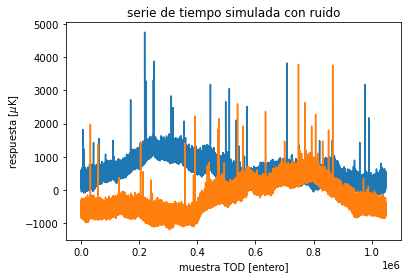

In [9]:
def sim_conjuntodatos(mapa, num_datos=2, dt=.00416, fcodo=0.1, alfa=3, sigma=40):
    """Simula un conjunto de datos que consta de num_datos escaneos en el cielo.
    Devuelve una lista de objetos de datos, cada uno de los cuales contiene tod,
    el puntero y el espectro de ruido."""
    res = []
    for i in range(num_datos):
        puntero = sim_puntero(mapa, i % 2)
        espectro_ruido = sim_espectro_ruido(puntero.shape[-1], dt=dt, fcodo=fcodo, alfa=alfa, sigma=sigma)
        tod = sim_tod(mapa, puntero, espectro_ruido)
        res.append(Datos(tod, puntero, espectro_ruido))
    return res


class Datos:
    def __init__(self, tod, puntero, espectro_ruido):
        self.tod   = tod
        self.puntero = puntero
        self.espectro_ruido = espectro_ruido

        
        
        
print("Generando una simulación de TOD ruidoso")
conjuntodatos  = sim_conjuntodatos(cielo,num_datos=2, dt=.00416, fcodo=0.1, alfa=3, sigma=40)
for datos in conjuntodatos:
    plt.plot(datos.tod)
    
plt.title("serie de tiempo simulada con ruido")
plt.ylabel("respuesta [$\mu$K]")
plt.xlabel("muestra TOD [entero]")
plt.show()

# Creación de mapas (de forma ingenua)

Hacer mapas a partir de TODs es un problema inverso. Se puede expresar en matrices como:
$$ P m = d.$$
Donde $d$ es el TOD (que es un vector), $m$ es el mapa del cielo (que también es un vector) y $P$ es una matriz (normalmente) rectangular que especifica qué píxel del mapa se observó durante cada muestra TOD. (NOTA: muchas muestras TOD generalmente corresponden al mismo píxel en nuestro mapa del cielo.


Para resolver para un mapa $m$ dado nuestros TODs ($d$) debemos invertir esta ecuación. La técnica estándar es utilizar la minimización chi-cuadrado. Expresado en matrices, esto se puede hacer de la siguiente forma:
$$ P m = d$$
$$ P^tP m  = P^t d      $$
$$ m = [P^tP]^{-1} P^t d.  $$

En otras palabras, podemos usar la matriz de puntos para construir una matriz $[P^tP]^{-1} P^t$ que actúa sobre los TOD para devolver una estimación del mapa. La dificultad es implementar esto cuando el número de muestras en los TOD es grande y en presencia de ruido.

Hemos ignorado por completo el ruido en este punto. (Las correlaciones de ruido se tratarán más adelante.
Sin embargo, en el límite donde el ruido es blanco, la ecuación anterior se puede resolver con un promedio agrupado simple. En este caso, uno simplemente promedia las muestras TOD que observan un píxel dado y devuelve un mapa compuesto por estos promedios. Implementamos esto a continuación y destacamos el valor y las limitaciones de dicho código. (El valor es que es rápido)


Resolviendo para un mapa mientras ignoramos correlaciones de ruido
promedio del mapa: 176.03443670586404 , media cuadrática (rms) del mapa: 278.4797047533168


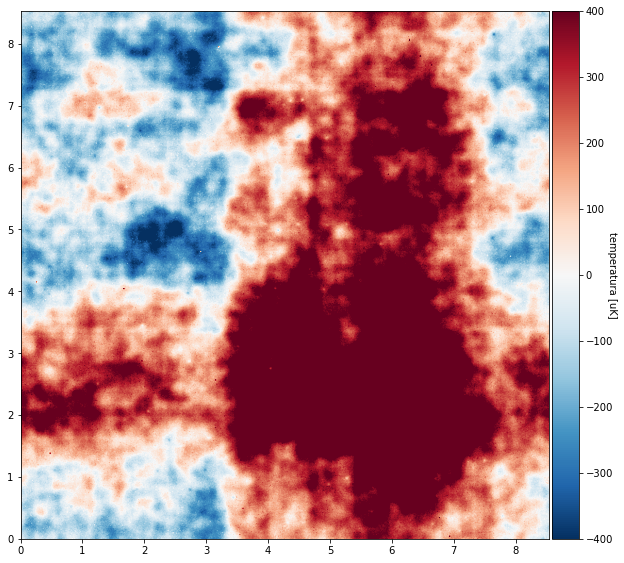

In [10]:
def resolver_promedio_agrupado(conjuntodatos, forma):
    """
    Resuelve la ecuación de mapeo simplificada Ax=b, donde A = P'P y b = P'd, ignorando propiedades del ruido 
    como las correlaciones.
    """
    ladoderecho  = np.zeros(forma)
    golpes = np.zeros(forma)
    for datos in conjuntodatos:
        ladoderecho  += PT(datos.tod,     datos.puntero, forma)
        golpes       += PT(datos.tod*0+1, datos.puntero, forma)
    return ladoderecho/golpes

def PT(tod, puntero, forma):
    """Transpuesta de la matriz de puntos"""
    puntero = np.round(puntero).astype(int)
    puntero_plano = np.ravel_multi_index(puntero, forma[-2:])
    mapa = np.bincount(puntero_plano, tod, minlength=forma[-2]*forma[-1])
    mapa = mapa.reshape(forma[-2:])
    return mapa

print("Resolviendo para un mapa mientras ignoramos correlaciones de ruido")
mapa_agrupado = resolver_promedio_agrupado(conjuntodatos, cielo.shape)
p=Graficar_Mapa_CMB(mapa_agrupado,c_min,c_max,X_ancho,Y_ancho)

#p=Graficar_Mapa_CMB(mapa_agrupado-cielo,c_min,c_max,X_ancho,Y_ancho)  #para comparar


<font color='red'>EJERCICIO: </font> ¿Ves estructuras comunes en este mapa y en el mapa del cielo de entrada?

comenta acá

<font color='red'>EJERCICIO: </font> Rehace el TOD y este mapa configurando la rodilla 1/f para que sea absurdamente pequeña. ¿Cómo se compara el nuevo resultado con el mapa de entrada original?


In [11]:
## tu código va aquí

comenta acá

<font color='red'>EJERCICIO: </font> Restablece el codo 1/f a su valor original. Ahora filtra la serie temporal usando un filtro de paso alto con una frecuencia de rodilla configurada para blanquear los TOD. Vuelve a crear el mapa y compara el nuevo resultado con el mapa de entrada. ¿Qué es diferente?

In [12]:
## tu código va aquí

comenta acá

# Creación de mapas usando máxima verosimilitud incluyendo correlaciones de ruido

En base a lo que hemos visto anteriormente, necesitamos desarrollar un método de creación de mapas que tenga en cuenta las correlaciones de ruido en nuestros datos. Para hacer esto, implementamos un método de elaboración de mapas de máxima verosimilitud. Expresado con matrices, esto es muy parecido a lo que hicimos anteriormente, excepto que incluimos la ponderación mediante una matriz $N;^{-2}$ cuyos elementos son $1/\sigma^2_{ij}$ y codifican el peso de cada muestra y correlaciones entre muestras en el TOD. Con esta matriz, nuestro método de creación de mapas se puede derivar de la siguiente manera:

$$ P m = d$$
$$ N^{-2} P m = N^{-2} d$$
$$ P^tN^{-2}P m  = P^tN^{-2} d      $$
$$ m = [P^tN^{-2}P]^{-1} P^tN^{-2} d.  $$

En resumen, nuestra matriz $[P^tN^{-2}P]^{-1} P^tN^{-2}$ se puede aplicar al TOD $d$ para producir el mapa $m$.

Dado que la matriz $N^{-2}$ debe tener términos fuera de la diagonal para codificar correlaciones de ruido como $1/f$, construir esta matriz es altamente no trivial. Por lo tanto, recurrimos a la técnica de gradiente conjugado [(ver artículo de Wikipedia)](https://es.wikipedia.org/wiki/M%C3%A9todo_del_gradiente_conjugado) para invertir esta ecuación sin construir explícitamente esta matriz. Estas técnicas son iterativas y, por lo tanto, debemos ejecutar muchas iteraciones para llegar a una estimación aceptable de nuestro mapa.

Ahora ejecutamos esto para mapas entrecruzados y no entrecruzados. Junto con más ejercicios.

Resolviendo el mapa mientras que se tienen en cuenta las correlaciones de ruido
iteración:    1 error de gradiente conjugado:   1.1334037e-02
iteración:    2 error de gradiente conjugado:   9.3733717e-04
iteración:    3 error de gradiente conjugado:   9.6402223e-05
iteración:    4 error de gradiente conjugado:   1.2637906e-05
iteración:    5 error de gradiente conjugado:   1.7633165e-07
iteración:    6 error de gradiente conjugado:   7.9269248e-09
iteración:    7 error de gradiente conjugado:   4.5454475e-10
iteración:    8 error de gradiente conjugado:   7.1927532e-12
iteración:    9 error de gradiente conjugado:   1.3849992e-13
iteración:   10 error de gradiente conjugado:   7.3571909e-15
iteración:   11 error de gradiente conjugado:   7.0444356e-16
iteración:   12 error de gradiente conjugado:   2.7432348e-15
iteración:   13 error de gradiente conjugado:   9.6369800e-14
iteración:   14 error de gradiente conjugado:   2.9189765e-12
iteración:   15 error de gradiente conjugado:   9.66

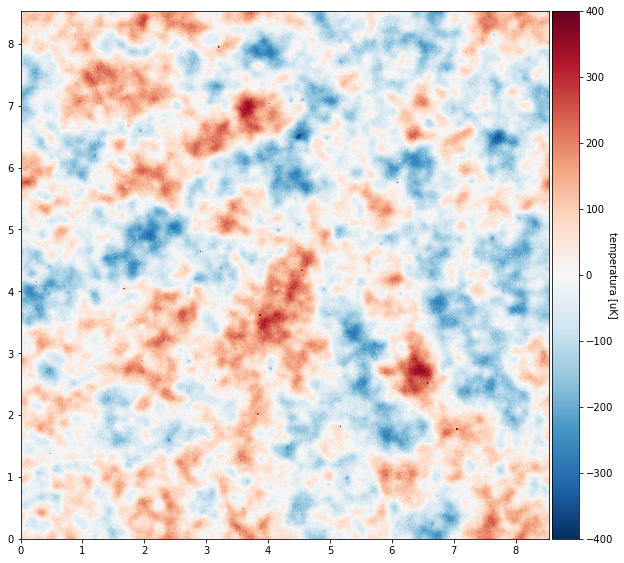

In [13]:
def resolver_todo(conjuntodatos, forma, niter=100, verbosa=True):
    """
    Resolver la ecuación completa de creación de mapas Ax=b, donde A = P'N"P y b = P'N"d.
    """
    
    #Configuramos nuestra matriz A. No la calculamos explícitamente porque es demasiado grande. 
    #En cambio, la definimos como una función que se puede aplicar a un vector x. Luego usaremos
    #gradientes conjugados para invertirla.
    def A(x):
        # x es 1d porque el gradiente conjudado trabaja en arreglos 1d. Por lo que partimos 
        # expandiendolo a 2d
        x   = x.reshape(forma)
        res = x*0
        for datos in conjuntodatos:
            tod  = Observar_mapa(x, datos.puntero)
            tod  = mul_ruido_inv(tod, datos.espectro_ruido)
            res += PT(tod, datos.puntero, forma)
        return res.reshape(-1)
    # Construimos el lado derecho b
    b = np.zeros(forma)
    for datos in conjuntodatos:
        tod = mul_ruido_inv(datos.tod, datos.espectro_ruido)
        b  += PT(tod, datos.puntero, forma)
    # Y resolvemos
    gc = GC(A, b.reshape(-1))
    while gc.i < niter:
        gc.paso()
        if verbosa: print("iteración: %4d error de gradiente conjugado: %15.7e" % (gc.i, gc.err))
    return gc.x.reshape(forma)



def mul_ruido_inv(tod, espectro_ruido):
    """
    Multiplicar por la matriz de ruido inversa. Suponemos que el ruido es estacionario, lo que significa 
    que puede ser representado por un simple espectro de potencia espectro_ruido. Esta función se utiliza 
    para aplicar ponderación por el inverso de la varianza de los datos."""
    ftod  = np.fft.fft(tod)
    ftod /= espectro_ruido
    return np.fft.ifft(ftod).real


def M_predeterminado(x):
    return np.copy(x)

def punto_determinado(a,b):
    return a.dot(np.conj(b))

class GC:
    """
    Un simple solucionador de gradientes conjugados precondicionados. Resuelve el sistema de ecuaciones 
    Ax=b.
    """
    def __init__(self, A, b, x0=None, M=M_predeterminado, dot=punto_determinado):
        """
        Inicializa un solucionador para el sistema Ax=b, con una suposición inicial de x0 (0 si no se proporciona). 
        Los vectores b y x0 deben proporcionar sumas y multiplicaciones, así como el método .copy(), como el que 
        proporcionan las matrices numpy. El precondicionador viene dado por M. A y M deben ser funciones que actúen 
        sobre vectores y retornen vectores. El producto escalar se puede especificar manualmente usando el argumen-
        to de punto Esto es útil para la paralelización MPI, por ejemplo.
        """
        # Inicializar parámetros
        self.A   = A
        self.b   = b
        self.M   = M
        self.dot = dot
        if x0 is None:
            self.x = b*0
            self.r = b
        else:
            self.x   = x0.copy()
            self.r   = b-self.A(self.x)
        # Variables para trabajar internamente
        n = b.size
        self.z   = self.M(self.r)
        self.rz  = self.dot(self.r, self.z)
        self.rz0 = float(self.rz)
        self.p   = self.z
        self.err = np.inf
        self.d   = 4
        self.arz = []
        self.i   = 0
    def paso(self):
        """
        Da un solo paso en la iteración. Resultando en .x, .i y .err siendo actualizados. Para resolver el sistema,
        se debe llamar a paso() en un bucle hasta que se esté satisfecho con la precisión. El resultado luego se 
        puede leer desde .x.
        """
        Ap = self.A(self.p)
        alfa = self.rz/self.dot(self.p, Ap)
        self.x += alfa*self.p
        self.r -= alfa*Ap
        self.z = self.M(self.r)
        siguiente_rz = self.dot(self.r, self.z)
        self.err = siguiente_rz/self.rz0
        beta = siguiente_rz/self.rz
        self.rz = siguiente_rz
        self.p = self.z + beta*self.p
        self.arz.append(self.rz*alfa)
        self.i += 1




print("Resolviendo el mapa mientras que se tienen en cuenta las correlaciones de ruido")
mapa_total  = resolver_todo(conjuntodatos, cielo.shape,niter=50)

p=Graficar_Mapa_CMB(mapa_total - np.mean(mapa_total),c_min,c_max,X_ancho,Y_ancho)

### mapas sin entrecruzado

Resolviendo el mapa mientras que se tienen en cuenta las correlaciones de ruido
iteración:    1 error de gradiente conjugado:   3.8688845e-03
iteración:    2 error de gradiente conjugado:   9.6566388e-05
iteración:    3 error de gradiente conjugado:   3.0305329e-06
iteración:    4 error de gradiente conjugado:   2.3698120e-06
iteración:    5 error de gradiente conjugado:   1.7026242e-06
iteración:    6 error de gradiente conjugado:   1.1004767e-06
iteración:    7 error de gradiente conjugado:   7.4203081e-07
iteración:    8 error de gradiente conjugado:   6.6941342e-07
iteración:    9 error de gradiente conjugado:   6.0061874e-07
iteración:   10 error de gradiente conjugado:   5.0183176e-07
iteración:   11 error de gradiente conjugado:   4.0468700e-07
iteración:   12 error de gradiente conjugado:   2.8839305e-07
iteración:   13 error de gradiente conjugado:   2.5983673e-07
iteración:   14 error de gradiente conjugado:   2.4329566e-07
iteración:   15 error de gradiente conjugado:   2.24

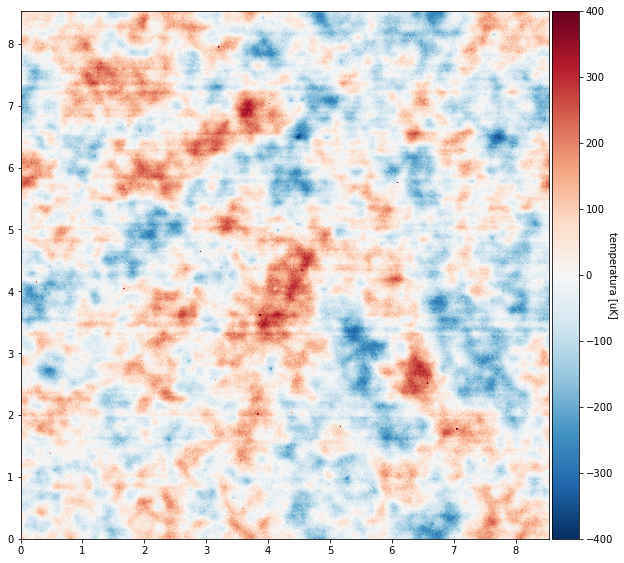

In [14]:
print("Resolviendo el mapa mientras que se tienen en cuenta las correlaciones de ruido")
mapa_unidir = resolver_todo(conjuntodatos[0:1], cielo.shape,niter=50)

p=Graficar_Mapa_CMB(mapa_unidir - np.mean(mapa_unidir),c_min,c_max,X_ancho,Y_ancho)



<font color='red'>EJERCICIO: </font> Compara los mapas entrecruzados y no entrecruzados. Las franjas horizontales en los mapas no entrecruzados se denominan (de forma poco creativa) franjas.

<font color='red'>EJERCICIO: </font> Haz graficos de estos mapas en espacio Fourier 2-d

In [15]:
## Tu código va aquí

Compara estos gráficos de Fourier 2D aquí. Asegurate de anotar dónde faltan o están desequilibrados los modos en cada mapa.
 
 

<font color='red'>EJERCICIO: </font>  Filtra el mapa no entrecruzado para eliminar las rayas. Esto se puede lograr enmascarando los modos relevantes de Fourier 2D antes de la transformación inversa de Fourier para crear el mapa.


In [16]:
## Tu código va aquí

comenta la diferencia entre el mapa no entrecruzado filtrado, el mapa entrecruzado, y el mapa de entrada. Haz gráficos de la resta de estos mapas.

